## 导包

In [11]:
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt
import pickle
import urllib
import gzip
import os

In [12]:
def dataloader(X, y, BATCH_SIZE):
    n = len(X)
    for t in range(0, n, BATCH_SIZE):
        yield X[t:t+BATCH_SIZE, ...], y[t:t+BATCH_SIZE, ...]
        
        
def get_indices(X_shape, HF, WF, stride, pad):
    # get input size
    m, n_C, n_H, n_W = X_shape

    # get output size
    out_h = int((n_H + 2 * pad - HF) / stride) + 1
    out_w = int((n_W + 2 * pad - WF) / stride) + 1
  
    # ----Compute matrix of index i----

    # Level 1 vector.
    level1 = np.repeat(np.arange(HF), WF)
    # Duplicate for the other channels.
    level1 = np.tile(level1, n_C)
    # Create a vector with an increase by 1 at each level.
    everyLevels = stride * np.repeat(np.arange(out_h), out_w)
    # Create matrix of index i at every levels for each channel.
    i = level1.reshape(-1, 1) + everyLevels.reshape(1, -1)

    # ----Compute matrix of index j----
    
    # Slide 1 vector.
    slide1 = np.tile(np.arange(WF), HF)
    # Duplicate for the other channels.
    slide1 = np.tile(slide1, n_C)
    # Create a vector with an increase by 1 at each slide.
    everySlides = stride * np.tile(np.arange(out_w), out_h)
    # Create matrix of index j at every slides for each channel.
    j = slide1.reshape(-1, 1) + everySlides.reshape(1, -1)

    # ----Compute matrix of index d----

    # This is to mark delimitation for each channel
    # during multi-dimensional arrays indexing.
    d = np.repeat(np.arange(n_C), HF * WF).reshape(-1, 1)

    return i, j, d

def im2col(X, HF, WF, stride, pad):
    # Padding
    X_padded = np.pad(X, ((0,0), (0,0), (pad, pad), (pad, pad)), mode='constant')
    i, j, d = get_indices(X.shape, HF, WF, stride, pad)
    # Multi-dimensional arrays indexing.
    cols = X_padded[:, d, i, j]
    cols = np.concatenate(cols, axis=-1)
    return cols

def col2im(dX_col, X_shape, HF, WF, stride, pad):
    # Get input size
    N, D, H, W = X_shape
    # Add padding if needed.
    H_padded, W_padded = H + 2 * pad, W + 2 * pad
    X_padded = np.zeros((N, D, H_padded, W_padded))
    
    # Index matrices, necessary to transform our input image into a matrix. 
    i, j, d = get_indices(X_shape, HF, WF, stride, pad)
    # Retrieve batch dimension by spliting dX_col N times: (X, Y) => (N, X, Y)
    dX_col_reshaped = np.array(np.hsplit(dX_col, N))
    # Reshape our matrix back to image.
    # slice(None) is used to produce the [::] effect which means "for every elements".
    np.add.at(X_padded, (slice(None), d, i, j), dX_col_reshaped)
    # Remove padding from new image if needed.
    if pad == 0:
        return X_padded
    elif type(pad) is int:
        return X_padded[pad:-pad, pad:-pad, :, :]
    
def download_mnist(filename):
    # Make data/ accessible from every folders.
    terminal_path = ['src/fast/data/', 'fast/data/', '../fast/data/', 'data/', '../data']
    dirPath = None
    for path in terminal_path:
        if os.path.isdir(path):
            dirPath = path
    if dirPath == None:
        raise FileNotFoundError("extract_mnist(): Impossible to find data/ from current folder. You need to manually add the path to it in the \'terminal_path\' list and the run the function again.")

    base_url = "http://yann.lecun.com/exdb/mnist/"
    for elt in filename:
        print("Downloading " + elt[1] + " in data/ ...")
        urllib.request.urlretrieve(base_url + elt[1], dirPath + elt[1])
    print("Download complete.")

def extract_mnist(filename):
    """
        Extracts dataset from filename.

        Parameters:
        - filename: [
                        ["training_images","train-images-idx3-ubyte.gz"],
                        ["test_images","t10k-images-idx3-ubyte.gz"],
                        ["training_labels","train-labels-idx1-ubyte.gz"],
                        ["test_labels","t10k-labels-idx1-ubyte.gz"]
                    ]
    """
    # Make data/ accessible from every folders.
    terminal_path = ['src/fast/data/', 'fast/data/', '../fast/data/', 'data/', '../data']
    dirPath = None
    for path in terminal_path:
        if os.path.isdir(path):
            dirPath = path
    if dirPath == None:
        raise FileNotFoundError("extract_mnist(): Impossible to find data/ from current folder. You need to manually add the path to it in the \'terminal_path\' list and the run the function again.")

    mnist = {}
    for elt in filename[:2]:
        print('Extracting data/' + elt[0] + '...')
        with gzip.open(dirPath + elt[1]) as f:
            #According to the doc on MNIST website, offset for image starts at 16.
            mnist[elt[0]] = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1, 1, 28, 28)
    
    for elt in filename[2:]:
        print('Extracting data/' + elt[0] + '...')
        with gzip.open(dirPath + elt[1]) as f:
            #According to the doc on MNIST website, offset for label starts at 8.
            mnist[elt[0]] = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

    print('Files extraction: OK') 

    return mnist


def one_hot_encoding(y):
    """
        Performs one-hot-encoding on y.
        
        Parameters:
        - y: ground truth labels.
    """
    N = y.shape[0]
    Z = np.zeros((N, 10))
    Z[np.arange(N), y] = 1
    return Z


def load(filename):
    """
        Loads dataset to variables.

        Parameters:
        - filename: [
                        ["training_images","train-images-idx3-ubyte.gz"],
                        ["test_images","t10k-images-idx3-ubyte.gz"],
                        ["training_labels","train-labels-idx1-ubyte.gz"],
                        ["test_labels","t10k-labels-idx1-ubyte.gz"]
                  ]
    """
    # Make data/ accessible from every folders.
    terminal_path = ['src/fast/data/', 'fast/data/', '../fast/data/', 'data/', '../data']
    dirPath = None
    for path in terminal_path:
        if os.path.isdir(path):
            dirPath = path
    if dirPath == None:
        raise FileNotFoundError("extract_mnist(): Impossible to find data/ from current folder. You need to manually add the path to it in the \'terminal_path\' list and the run the function again.")

    L = [elt[1] for elt in filename]   
    count = 0 

    #Check if the 4 .gz files exist.
    for elt in L:
        if os.path.isfile(dirPath + elt):
            count += 1

    #If the 4 .gz are not in data/, we download and extract them.
    if count != 4:
        download_mnist(filename)
        mnist = extract_mnist(filename)
    else: #We just extract them.
        mnist = extract_mnist(filename)

    print('Loading dataset: OK')
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]
    
    
def save_params_to_file(model):
    # Make save_weights/ accessible from every folders.
    terminal_path = ["src/fast/save_weights/", "fast/save_weights/", '../fast/save_weights/', "save_weights/", "../save_weights/"]
    dirPath = None
    for path in terminal_path:
        if os.path.isdir(path):
            dirPath = path
    if dirPath == None:
        raise FileNotFoundError("save_params_to_file(): Impossible to find save_weights/ from current folder. You need to manually add the path to it in the \'terminal_path\' list and the run the function again.")

    weights = model.get_params()
    if dirPath == '../fast/save_weights/': # We run the code from demo notebook.
        with open(dirPath + "demo_weights.pkl","wb") as f:
            pickle.dump(weights, f)
    else:
        with open(dirPath + "final_weights.pkl","wb") as f:
            pickle.dump(weights, f)

def load_params_from_file(model, isNotebook=False):
    if isNotebook: # We run from demo-notebooks/
        pickle_in = open("../fast/save_weights/demo_weights.pkl", 'rb')
        params = pickle.load(pickle_in)
        model.set_params(params)
    else:
        # Make final_weights.pkl file accessible from every folders.
        terminal_path = ["src/fast/save_weights/final_weights.pkl", "fast/save_weights/final_weights.pkl",
        "save_weights/final_weights.pkl", "../save_weights/final_weights.pkl"]

        filePath = None
        for path in terminal_path:
            if os.path.isfile(path):
                filePath = path
        if filePath == None:
            raise FileNotFoundError('load_params_from_file(): Cannot find final_weights.pkl from your current folder. You need to manually add it to terminal_path list and the run the function again.')

        pickle_in = open(filePath, 'rb')
        params = pickle.load(pickle_in)
        model.set_params(params)
    return model


def plot_example(X, y, y_pred=None):
    """
        Plots 9 examples and their associate labels.
        
        Parameters:
        -X: Training examples.
        -y: true labels.
        -y_pred: predicted labels.
    """
    # Create figure with 3 x 3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
     
    X, y = X[:9, 0, ...], y[:9] 
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(X[i])

        # Show true and predicted classes.
        if y_pred is None:
            xlabel = "True: {0}".format(y[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(y[i], y_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()

def plot_example_errors(X, y, y_pred):
    incorrect = (y != y_pred)
 
    X = X[incorrect]
    y = y[incorrect]
    y_pred = y_pred[incorrect]

    # Plot the first 9 images.
    plot_example(X, y, y_pred)
    

def resize_dataset(dataset):
    # 获取输入数据的形状信息
    num_samples, num_channels, height, width = dataset.shape

    # 创建一个新的数组来存储调整大小后的图像
    resized_dataset = np.zeros((num_samples, num_channels, 32, 32))

    # 计算上下左右填充的像素数
    pad_top = (32 - height) // 2
    pad_bottom = 32 - height - pad_top
    pad_left = (32 - width) // 2
    pad_right = 32 - width - pad_left

    # 对每个样本进行调整大小操作
    for i in range(num_samples):
        # 获取当前样本的图像数据
        image = dataset[i, 0, :, :]

        # 使用0填充调整图像大小
        resized_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')

        # 将调整大小后的图像存储到新的数组中
        resized_dataset[i, 0, :, :] = resized_image

    return resized_dataset 


## Layer Classes
- Conv
- AvgPool
- Fc
- SGD
- AdamSGD
- TanH
- Softmax
- CrossEntropyLoss

In [13]:
class Conv():
    
    def __init__(self, nb_filters, filter_size, nb_channels, stride=1, padding=0):
        self.n_F = nb_filters
        self.f = filter_size
        self.n_C = nb_channels
        self.s = stride
        self.p = padding

        # Xavier-Glorot initialization - used for sigmoid, tanh.
        self.W = {'val': np.random.randn(self.n_F, self.n_C, self.f, self.f) * np.sqrt(1. / (self.f)),
                  'grad': np.zeros((self.n_F, self.n_C, self.f, self.f))}  
        self.b = {'val': np.random.randn(self.n_F) * np.sqrt(1. / self.n_F), 'grad': np.zeros((self.n_F))}

        self.cache = None

    def forward(self, X):
        m, n_C_prev, n_H_prev, n_W_prev = X.shape

        n_C = self.n_F
        n_H = int((n_H_prev + 2 * self.p - self.f)/ self.s) + 1
        n_W = int((n_W_prev + 2 * self.p - self.f)/ self.s) + 1
        
        X_col = im2col(X, self.f, self.f, self.s, self.p)
        w_col = self.W['val'].reshape((self.n_F, -1))
        b_col = self.b['val'].reshape(-1, 1)
        # Perform matrix multiplication.
        out = w_col @ X_col + b_col
        # Reshape back matrix to image.
        out = np.array(np.hsplit(out, m)).reshape((m, n_C, n_H, n_W))
        self.cache = X, X_col, w_col
        return out

    def backward(self, dout):
        X, X_col, w_col = self.cache
        m, _, _, _ = X.shape
        # Compute bias gradient.
        self.b['grad'] = np.sum(dout, axis=(0,2,3))
        # Reshape dout properly.
        dout = dout.reshape(dout.shape[0] * dout.shape[1], dout.shape[2] * dout.shape[3])
        dout = np.array(np.vsplit(dout, m))
        dout = np.concatenate(dout, axis=-1)
        # Perform matrix multiplication between reshaped dout and w_col to get dX_col.
        dX_col = w_col.T @ dout
        # Perform matrix multiplication between reshaped dout and X_col to get dW_col.
        dw_col = dout @ X_col.T
        # Reshape back to image (col2im).
        dX = col2im(dX_col, X.shape, self.f, self.f, self.s, self.p)
        # Reshape dw_col into dw.
        self.W['grad'] = dw_col.reshape((dw_col.shape[0], self.n_C, self.f, self.f))
                
        return dX, self.W['grad'], self.b['grad']

class AvgPool():
    
    def __init__(self, filter_size, stride=1, padding=0):
        self.f = filter_size
        self.s = stride
        self.p = padding
        self.cache = None

    def forward(self, X):
        self.cache = X

        m, n_C_prev, n_H_prev, n_W_prev = X.shape
        n_C = n_C_prev
        n_H = int((n_H_prev + 2 * self.p - self.f)/ self.s) + 1
        n_W = int((n_W_prev + 2 * self.p - self.f)/ self.s) + 1
        
        X_col = im2col(X, self.f, self.f, self.s, self.p)
        X_col = X_col.reshape(n_C, X_col.shape[0]//n_C, -1)
        A_pool = np.mean(X_col, axis=1)
        # Reshape A_pool properly.
        A_pool = np.array(np.hsplit(A_pool, m))
        A_pool = A_pool.reshape(m, n_C, n_H, n_W)

        return A_pool

    def backward(self, dout):
        X = self.cache
        m, n_C_prev, n_H_prev, n_W_prev = X.shape

        n_C = n_C_prev
        n_H = int((n_H_prev + 2 * self.p - self.f)/ self.s) + 1
        n_W = int((n_W_prev + 2 * self.p - self.f)/ self.s) + 1

        dout_flatten = dout.reshape(n_C, -1) / (self.f * self.f)
        dX_col = np.repeat(dout_flatten, self.f*self.f, axis=0)
        dX = col2im(dX_col, X.shape, self.f, self.f, self.s, self.p)
        # Reshape dX properly.
        dX = dX.reshape(m, -1)
        dX = np.array(np.hsplit(dX, n_C_prev))
        dX = dX.reshape(m, n_C_prev, n_H_prev, n_W_prev)
        return dX

class Fc():

    def __init__(self, row, column):
        self.row = row
        self.col = column

        # Xavier-Glorot initialization - used for sigmoid, tanh.
        self.W = {'val': np.random.randn(self.row, self.col) * np.sqrt(1./self.col), 'grad': 0}
        self.b = {'val': np.random.randn(1, self.row) * np.sqrt(1./self.row), 'grad': 0}
        
        self.cache = None

    def forward(self, fc):
        self.cache = fc
        A_fc = np.dot(fc, self.W['val'].T) + self.b['val']
        return A_fc

    def backward(self, deltaL):
        fc = self.cache
        m = fc.shape[0]

        #Compute gradient.
        self.W['grad'] = (1/m) * np.dot(deltaL.T, fc)
        self.b['grad'] = (1/m) * np.sum(deltaL, axis = 0)

        #Compute error.
        new_deltaL = np.dot(deltaL, self.W['val']) 
        #We still need to multiply new_deltaL by the derivative of the activation
        #function which is done in TanH.backward().
        return new_deltaL, self.W['grad'], self.b['grad']
    
class SGD():

    def __init__(self, lr, params):
        self.lr = lr
        self.params = params

    def update_params(self, grads):
        for key in self.params:
            self.params[key] = self.params[key] - self.lr * grads['d' + key]
        return self.params        

class AdamGD():

    def __init__(self, lr, beta1, beta2, epsilon, params):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.params = params
        
        self.momentum = {}
        self.rmsprop = {}

        for key in self.params:
            self.momentum['vd' + key] = np.zeros(self.params[key].shape)
            self.rmsprop['sd' + key] = np.zeros(self.params[key].shape)

    def update_params(self, grads):
        
        for key in self.params:
            # Momentum update.
            self.momentum['vd' + key] = (self.beta1 * self.momentum['vd' + key]) + (1 - self.beta1) * grads['d' + key] 
            # RMSprop update.
            self.rmsprop['sd' + key] =  (self.beta2 * self.rmsprop['sd' + key]) + (1 - self.beta2) * (grads['d' + key]**2)
            # Update parameters.
            self.params[key] = self.params[key] - (self.lr * self.momentum['vd' + key]) / (np.sqrt(self.rmsprop['sd' + key]) + self.epsilon)  

        return self.params

class TanH():
 
    def __init__(self, alpha = 1.7159):
        self.alpha = alpha
        self.cache = None

    def forward(self, X):
        self.cache = X
        return self.alpha * np.tanh(X)

    def backward(self, new_deltaL):
        X = self.cache
        return new_deltaL * (1 - np.tanh(X)**2)

class Softmax():
    
    def __init__(self):
        pass

    def forward(self, X):
        e_x = np.exp(X - np.max(X))
        return  e_x / np.sum(e_x, axis=1)[:, np.newaxis]

    def backward(self, y_pred, y):
        return y_pred - y

class CrossEntropyLoss():

    def __init__(self):
        pass
    
    def get(self, y_pred, y):
        loss = -np.sum(y * np.log(y_pred))
        return loss

## Model

In [14]:
class LeNet5():

    def __init__(self):
        self.conv1 = Conv(nb_filters = 6, filter_size = 5, nb_channels = 1)
        self.tanh1 = TanH()
        self.pool1 = AvgPool(filter_size = 2, stride = 2)
        self.conv2 = Conv(nb_filters = 16, filter_size = 5, nb_channels = 6)
        self.tanh2 = TanH()
        self.pool2 = AvgPool(filter_size = 2, stride = 2)
        self.pool2_shape = None
        self.fc1 = Fc(row = 120, column = 5*5*16)
        self.tanh3 = TanH()
        self.fc2 = Fc(row = 84, column = 120)
        self.tanh4 = TanH()
        self.fc3 = Fc(row = 10 , column = 84)
        self.softmax = Softmax()

        self.layers = [self.conv1, self.conv2, self.fc1, self.fc2, self.fc3]


    def forward(self, X):
        conv1 = self.conv1.forward(X) #(6x28x28)
        act1 = self.tanh1.forward(conv1)
        pool1 = self.pool1.forward(act1) #(6x14x14)

        conv2 = self.conv2.forward(pool1) #(16x10x10)
        act2 = self.tanh2.forward(conv2)
        pool2 = self.pool2.forward(act2) #(16x5x5)
        
        self.pool2_shape = pool2.shape #Need it in backpropagation.
        pool2_flatten = pool2.reshape(self.pool2_shape[0], -1) #(1x400)
    
        fc1 = self.fc1.forward(pool2_flatten) #(1x120)
        act3 = self.tanh3.forward(fc1)
        
        fc2 = self.fc2.forward(act3) #(1x84)
        act4 = self.tanh4.forward(fc2)
        
        fc3 = self.fc3.forward(act4) #(1x10)
    
        y_pred = self.softmax.forward(fc3)

        return y_pred
        
    def backward(self, y_pred, y):
        deltaL = self.softmax.backward(y_pred, y)
        #Compute gradient for weight/bias between fc3 and fc2.
        deltaL, dW5, db5, = self.fc3.backward(deltaL)
        #Compute error at fc2 layer.
        deltaL = self.tanh4.backward(deltaL) #(1x84) 
        
        #Compute gradient for weight/bias between fc2 and fc1.
        deltaL, dW4, db4 = self.fc2.backward(deltaL)
        #Compute error at fc1 layer.
        deltaL = self.tanh3.backward(deltaL) #(1x120)
        
        deltaL, dW3, db3 = self.fc1.backward(deltaL) #(1x400)
        deltaL = deltaL.reshape(self.pool2_shape) #(16x5x5)
        
        #Distribute error through pool2 to conv2.
        deltaL = self.pool2.backward(deltaL) #(16x10x10)
        #Distribute error through tanh.
        deltaL = self.tanh2.backward(deltaL)
        
        deltaL, dW2, db2 = self.conv2.backward(deltaL) #(6x14x14)

        #Distribute error through pool1 by creating a temporary pooling layer
        #of conv1 shape.
        deltaL = self.pool1.backward(deltaL) #(6x28x28)
        #Distribute error through tanh.
        deltaL = self.tanh1.backward(deltaL)
    
        deltaL, dW1, db1 = self.conv1.backward(deltaL) #(1x32x32)
    
        grads = { 
                'dW1': dW1, 'db1': db1,
                'dW2': dW2, 'db2': db2, 
                'dW3': dW3, 'db3': db3,
                'dW4': dW4, 'db4': db4,
                'dW5': dW5, 'db5': db5
        }

        return grads

    def get_params(self):
        params = {}
        for i, layer in enumerate(self.layers):
            params['W' + str(i+1)] = layer.W['val']
            params['b' + str(i+1)] = layer.b['val']

        return params

    def set_params(self, params):
        for i, layer in enumerate(self.layers):
            layer.W['val'] = params['W'+ str(i+1)]
            layer.b['val'] = params['b' + str(i+1)]  

## Load Data

In [15]:
filename = [
        ["training_images","train-images-idx3-ubyte.gz"],
        ["test_images","t10k-images-idx3-ubyte.gz"],
        ["training_labels","train-labels-idx1-ubyte.gz"],
        ["test_labels","t10k-labels-idx1-ubyte.gz"]
]

print("\n----------------EXTRACTION---------------\n")
X, y, X_test, y_test = load(filename)


----------------EXTRACTION---------------

Extracting data/training_images...
Extracting data/test_images...
Extracting data/training_labels...
Extracting data/test_labels...
Files extraction: OK
Loading dataset: OK


## Data Pre-Process

In [16]:
# X X_test 归一化
X, X_test = X/float(255), X_test/float(255)
X -= np.mean(X)
X_test -= np.mean(X_test)

# 预处理
print("\n--------------PREPROCESSING--------------\n")
X = resize_dataset(X)
X_test = resize_dataset(X)
print("Resize dataset: OK")
y = one_hot_encoding(y)
y_test = one_hot_encoding(y_test)
print("One-Hot-Encoding: OK")

X_train = X
y_train = y
print("Train and Validation set split: OK\n")


--------------PREPROCESSING--------------
Resize dataset: OK
One-Hot-Encoding: OK
Train and Validation set split: OK


## Model & Loss & Optimizer

In [17]:
model = LeNet5()
cost = CrossEntropyLoss()
lr = 0.001
optimizer = AdamGD(lr = lr, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8, params = model.get_params())    

## Train
- 使用Accuracy来评估

In [18]:
train_costs, val_costs = [], []

print("----------------TRAINING-----------------\n")

NB_EPOCH = 1
BATCH_SIZE = 100

print("EPOCHS: {}".format(NB_EPOCH))
print("BATCH_SIZE: {}".format(BATCH_SIZE))
print("LR: {}".format(lr))
print()

nb_train_examples = len(X_train)
# nb_val_examples = len(X_val)

best_val_loss = float('inf')


for epoch in range(NB_EPOCH):

    #-------------------------------------------------------------------------------
    #                                       
    #                               TRAINING PART
    #
    #-------------------------------------------------------------------------------
    
    train_loss = 0
    train_acc = 0 

    pbar = trange(nb_train_examples // BATCH_SIZE)
    train_loader = dataloader(X_train, y_train, BATCH_SIZE)

    # start = timer()

    for i, (X_batch, y_batch) in zip(pbar, train_loader):
        
        y_pred = model.forward(X_batch)
        loss = cost.get(y_pred, y_batch)

        grads = model.backward(y_pred, y_batch)
        params = optimizer.update_params(grads)
        model.set_params(params)

        train_loss += loss * BATCH_SIZE
        train_acc += sum((np.argmax(y_batch, axis=1) == np.argmax(y_pred, axis=1)))

        pbar.set_description("[Train] Epoch {}".format(epoch+1))
    
    # end = timer()

    train_loss /= nb_train_examples
    train_costs.append(train_loss)
    train_acc /= nb_train_examples

    info_train = "train-loss: {:0.6f} | train-acc: {:0.3f}"
    print(info_train.format(train_loss, train_acc))

----------------TRAINING-----------------

EPOCHS: 1
BATCH_SIZE: 100
LR: 0.001


[Train] Epoch 1: 100%|██████████| 600/600 [03:35<00:00,  2.79it/s]

train-loss: 19.500273 | train-acc: 0.941


In [19]:
    # Save model
    save_params_to_file(model)

## Test
- 使用Accuracy来评估


--------------------EXTRACTION-------------------

Extracting data/training_images...
Extracting data/test_images...
Extracting data/training_labels...
Extracting data/test_labels...
Files extraction: OK
Loading dataset: OK

------------------PREPROCESSING------------------

Resize dataset: OK
One-Hot-Encoding: OK

--------------LOAD PRETRAINED MODEL--------------

Load pretrained model: OK

--------------------EVALUATION-------------------


Evaluation: 100%|██████████| 100/100 [00:06<00:00, 14.30it/s]


test-loss: 14.852926 | test-acc: 0.954

Some correct classification:


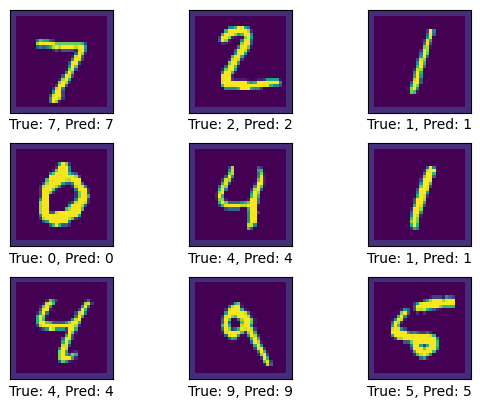


Some incorrect classification:


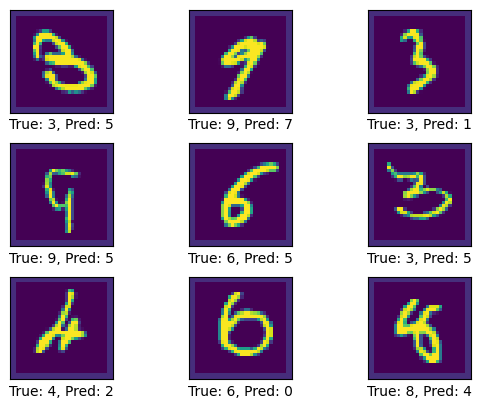

In [20]:
filename = [
        ["training_images","train-images-idx3-ubyte.gz"],
        ["test_images","t10k-images-idx3-ubyte.gz"],
        ["training_labels","train-labels-idx1-ubyte.gz"],
        ["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def test(isNotebook=False):
    print("\n--------------------EXTRACTION-------------------\n")
    X, y, X_test, y_test = load(filename)
    X = (X - np.mean(X)) / np.std(X)
    X_test = (X_test - np.mean(X_test)) / np.std(X_test)

    print("\n------------------PREPROCESSING------------------\n")
    X_test = resize_dataset(X_test)
    print("Resize dataset: OK")
    y_test = one_hot_encoding(y_test)
    print("One-Hot-Encoding: OK")
   
    print("\n--------------LOAD PRETRAINED MODEL--------------\n")
    cost = CrossEntropyLoss()
    model = LeNet5()
    model = load_params_from_file(model, isNotebook=isNotebook)
    print("Load pretrained model: OK\n")

    print("--------------------EVALUATION-------------------\n")
    
    BATCH_SIZE = 100

    nb_test_examples = len(X_test)
    test_loss = 0
    test_acc = 0 

    pbar = trange(nb_test_examples // BATCH_SIZE)
    test_loader = dataloader(X_test, y_test, BATCH_SIZE)

    for i, (X_batch, y_batch) in zip(pbar, test_loader):
      
        y_pred = model.forward(X_batch)
        loss = cost.get(y_pred, y_batch)

        test_loss += loss * BATCH_SIZE
        test_acc += sum((np.argmax(y_batch, axis=1) == np.argmax(y_pred, axis=1)))
        
        pbar.set_description("Evaluation")
    
    test_loss /= nb_test_examples
    test_acc /= nb_test_examples

    info_test = "test-loss: {:0.6f} | test-acc: {:0.3f}"
    print(info_test.format(test_loss, test_acc))

    # Display correct examples.
    images, labels = X_test[:1000, ...], y_test[:1000, ...]
    y_pred = model.forward(images)
    predicted, labels= np.argmax(y_pred, axis=1), np.argmax(labels, axis=1)
    print('\nSome correct classification:')
    plot_example(images, labels, predicted)

    # Display wrong examples.
    print('\nSome incorrect classification:')
    plot_example_errors(images, labels, predicted)

test()